<a href="https://colab.research.google.com/github/AhzyUmair/MedGuard-AI-Intelligent-Anomaly-Detection-System-/blob/main/Prototype%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Network Anamoly part**

NETWORK TRAFFIC ANOMALY DETECTION SYSTEM
Loading network data from network_data.csv...
Loaded 50000 records with 16 columns.
Columns: Source_IP, Destination_IP, Protocol, Packet_Size, Duration, Flags, Timestamp, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10, Unnamed: 11, Unnamed: 12, Unnamed: 13, Unnamed: 14, Unnamed: 15
Detecting anomalies in network traffic...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


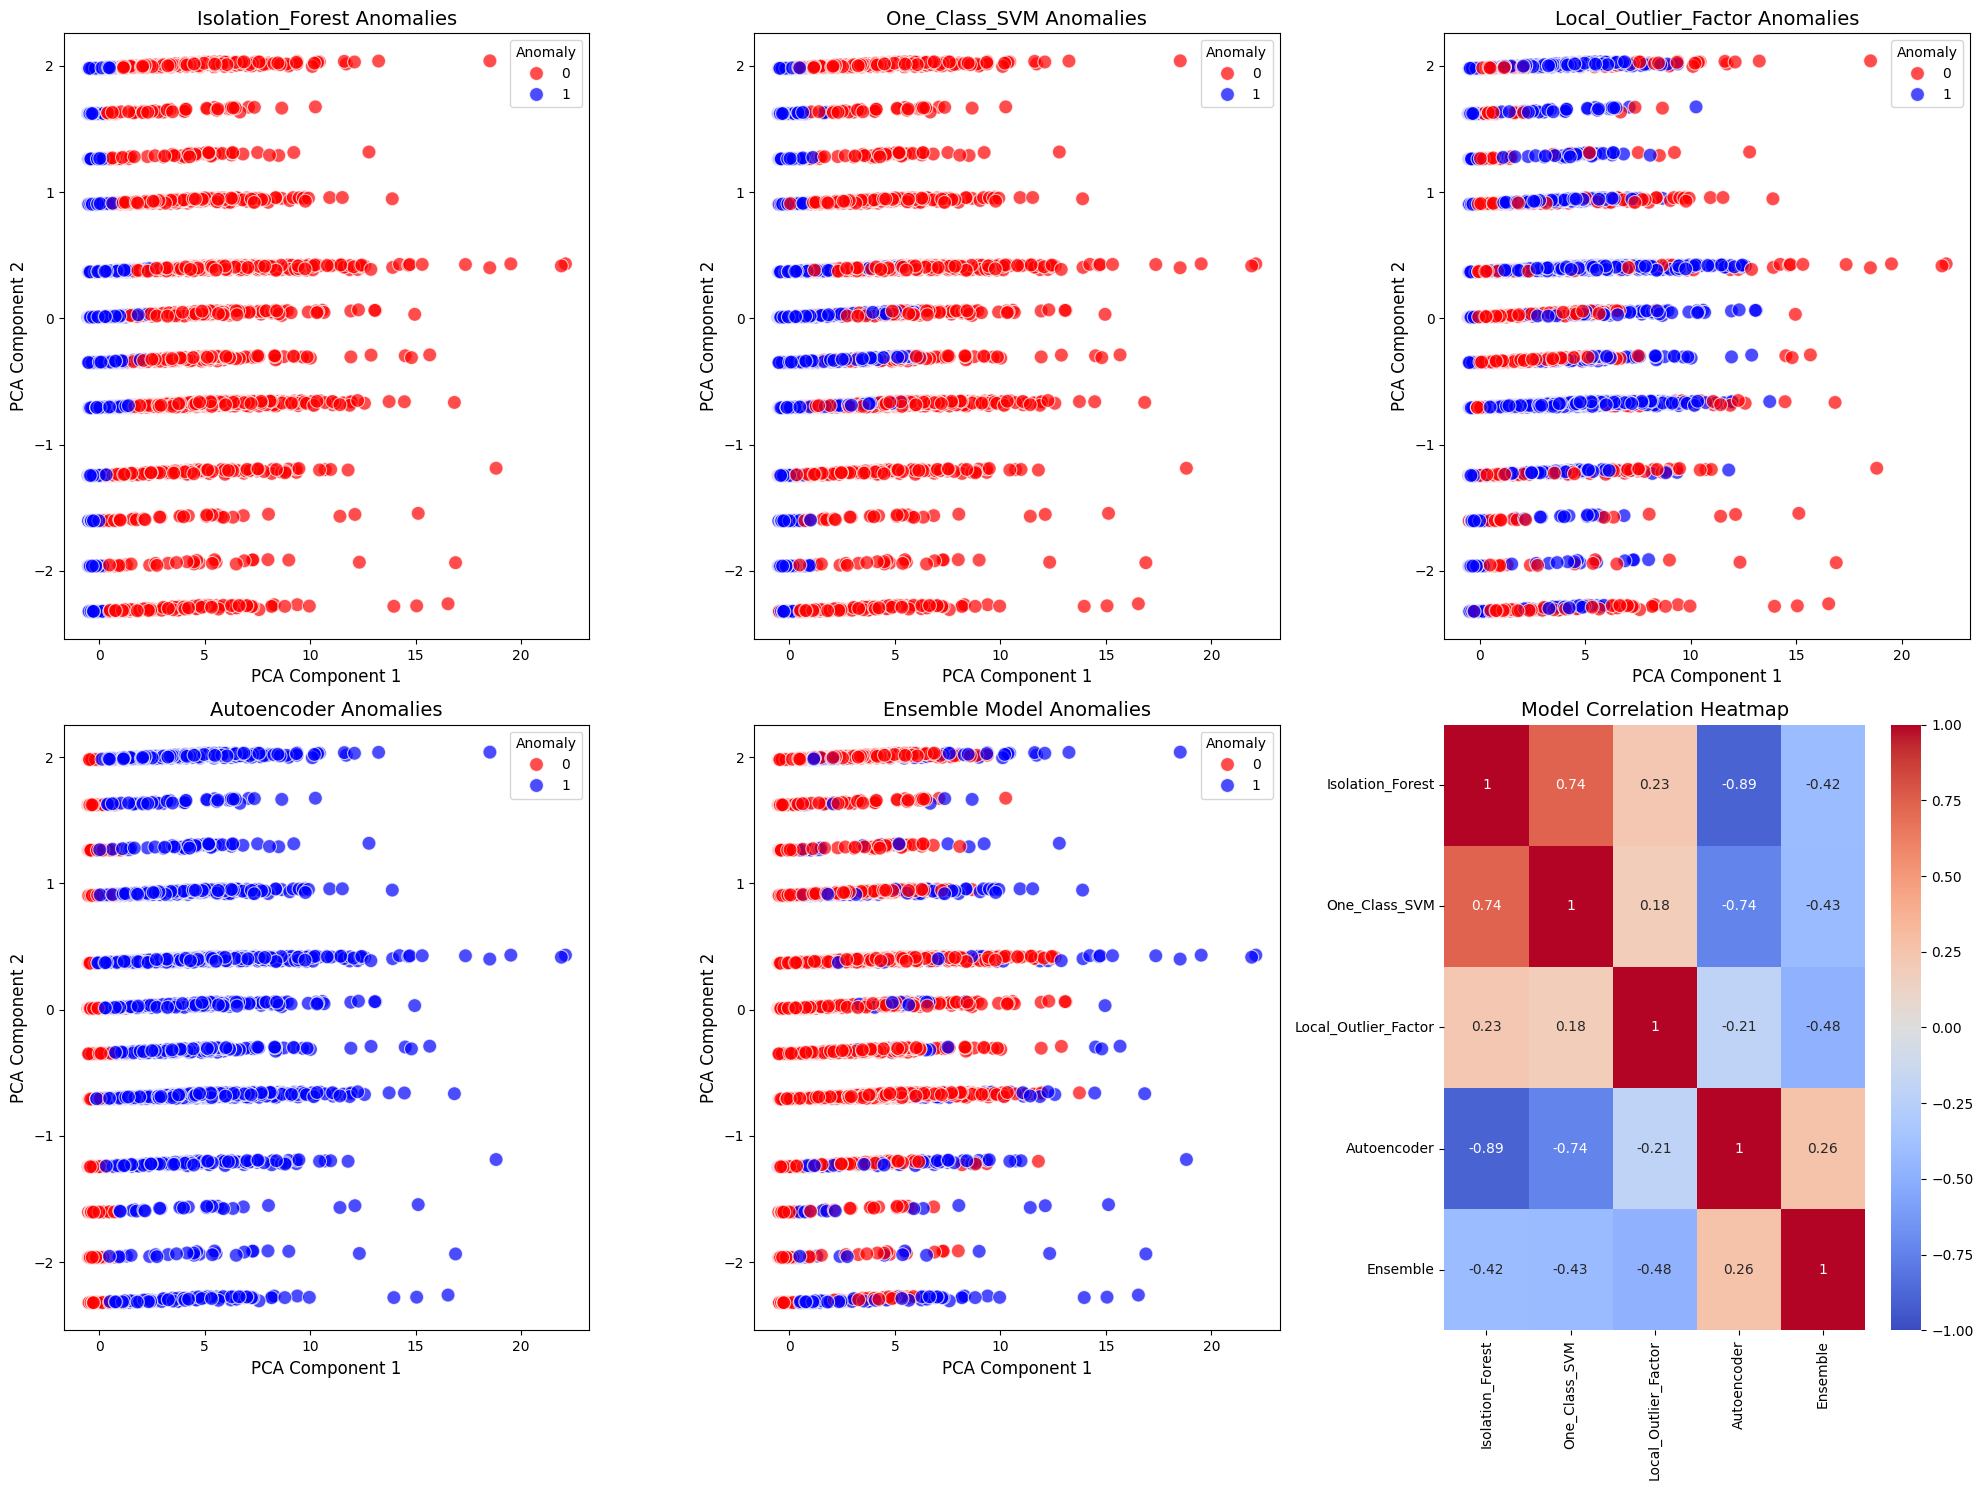

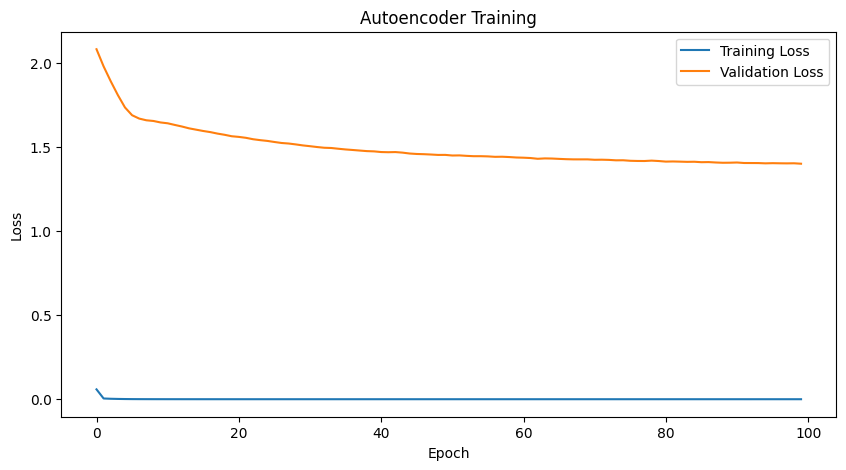


Detected 638 anomalies (1.28% of traffic)

Anomalies by Protocol:
Protocol
ICMP    259
UDP     220
TCP     159
Name: count, dtype: int64

Anomalies by Flag:
Flags
ACK    247
SYN    245
RST     78
FIN     68
Name: count, dtype: int64

Source IPs with Multiple Anomalies:
Source_IP
192.168.223.6     2
192.168.238.11    2
192.168.239.32    2
192.168.177.28    2
192.168.69.15     2
192.168.61.45     2
192.168.220.23    2
192.168.169.32    2
192.168.238.33    2
192.168.142.42    2
192.168.240.27    2
192.168.191.43    2
192.168.92.5      2
192.168.234.11    2
192.168.66.5      2
192.168.24.5      2
192.168.82.16     2
192.168.103.25    2
192.168.215.13    2
Name: count, dtype: int64


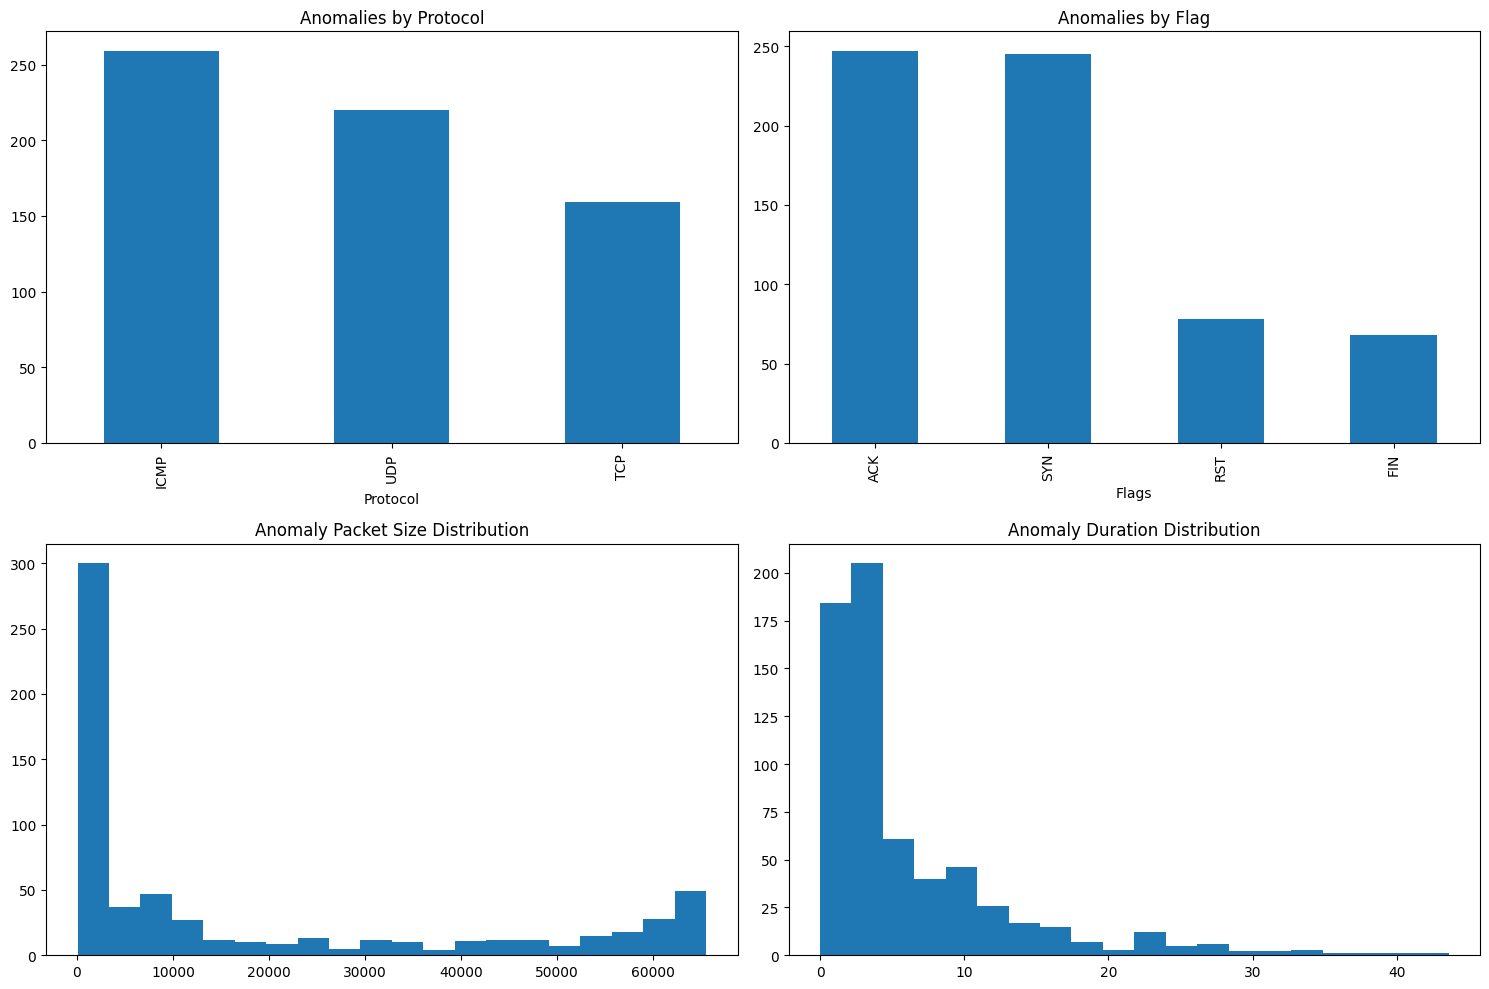

Detected anomalies (638 records) saved to 'network_anomalies_detected.csv'

Analysis complete. Thank you for using the Network Traffic Anomaly Detection System.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import warnings
import os

warnings.filterwarnings("ignore")
np.random.seed(42)

class NetworkAnomalyDetector:
    def __init__(self):
        self.isolation_forest = IsolationForest(contamination=0.05, random_state=42)
        self.one_class_svm = OneClassSVM(nu=0.05)
        self.local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.email_config = {
            "sender_email": "stupidstuff963@gmail.com",
            "receiver_email": "ahzyfdd963@gmail.com",
            "password": "Iflaas963@",
            "smtp_server": "smtp.gmail.com",
            "smtp_port": 587
        }

    def load_network_data(self, file_path='network_data.csv'):
        """Load network data from CSV file"""
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist.")

        # Load the data
        print(f"Loading network data from {file_path}...")
        df = pd.read_csv(file_path)

        # Print information about loaded data
        print(f"Loaded {len(df)} records with {len(df.columns)} columns.")
        print("Columns:", ", ".join(df.columns))

        # Check for required columns
        required_columns = ["Source_IP", "Destination_IP", "Protocol", "Packet_Size", "Duration", "Flags"]
        missing_columns = [col for col in required_columns if col not in df.columns]

        if missing_columns:
            raise ValueError(f"Missing required columns: {', '.join(missing_columns)}")

        # If 'Timestamp' column is not present, add it
        if 'Timestamp' not in df.columns:
            df['Timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq='10S')

        return df

    def preprocess_data(self, df):
        """Preprocess network data for anomaly detection"""
        # Encode categorical features
        df["Protocol_Encoded"] = self.label_encoder.fit_transform(df["Protocol"])
        df["Flags_Encoded"] = self.label_encoder.fit_transform(df["Flags"])

        return df

    def train_autoencoder(self, X_scaled):
        """Train an autoencoder model for anomaly detection"""
        input_dim = X_scaled.shape[1]
        encoding_dim = 8

        # Build encoder
        input_layer = Input(shape=(input_dim,))
        encoder = Dense(32, activation="tanh")(input_layer)
        encoder = Dense(16, activation="tanh")(encoder)
        encoder = Dense(encoding_dim, activation="tanh")(encoder)

        # Build decoder
        decoder = Dense(16, activation="tanh")(encoder)
        decoder = Dense(32, activation="tanh")(decoder)
        decoder = Dense(input_dim, activation="linear")(decoder)

        # Autoencoder model
        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

        # Train
        history = autoencoder.fit(
            X_scaled, X_scaled,
            epochs=100,
            batch_size=256,
            validation_split=0.2,
            verbose=0,
            shuffle=True
        )

        return autoencoder, history

    def detect_anomalies(self, df):
        """Detect anomalies in network traffic using multiple algorithms"""
        # Preprocess the data
        df = self.preprocess_data(df)


        # Extract features for anomaly detection
        features = ["Packet_Size", "Duration", "Protocol_Encoded", "Flags_Encoded"]
        X = df[features]

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # 1. Isolation Forest
        self.isolation_forest.fit(X_scaled)
        df["Isolation_Forest"] = self.isolation_forest.predict(X_scaled)
        df["Isolation_Forest"] = df["Isolation_Forest"].apply(lambda x: 0 if x == -1 else 1)  # 1 = Normal, 0 = Anomaly

        # 2. One-Class SVM
        self.one_class_svm.fit(X_scaled)
        df["One_Class_SVM"] = self.one_class_svm.predict(X_scaled)
        df["One_Class_SVM"] = df["One_Class_SVM"].apply(lambda x: 0 if x == -1 else 1)

        # 3. Local Outlier Factor
        df["Local_Outlier_Factor"] = self.local_outlier_factor.fit_predict(X_scaled)
        df["Local_Outlier_Factor"] = df["Local_Outlier_Factor"].apply(lambda x: 0 if x == -1 else 1)

        # 4. Autoencoder
        autoencoder, history = self.train_autoencoder(X_scaled)
        reconstructions = autoencoder.predict(X_scaled)
        mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
        threshold = np.percentile(mse, 95)
        df["Autoencoder"] = (mse > threshold).astype(int)

        # 5. Ensemble voting (majority vote)
        df["Ensemble"] = ((df["Isolation_Forest"] + df["One_Class_SVM"] +
                           df["Local_Outlier_Factor"] + df["Autoencoder"]) < 2).astype(int)

        # Save autoencoder and history for later use
        self.autoencoder = autoencoder
        self.history = history

        return df

    def evaluate_models(self, df):
        """Evaluate model performance using metrics"""
        # If there's a 'True_Anomaly' column in the data, use it for evaluation
        if 'True_Anomaly' in df.columns:
            models = ["Isolation_Forest", "One_Class_SVM", "Local_Outlier_Factor", "Autoencoder", "Ensemble"]
            results = []

            print("\n===== Model Evaluation =====")
            for model in models:
                cm = confusion_matrix(df["True_Anomaly"], df[model])
                f1 = f1_score(df["True_Anomaly"], df[model])
                report = classification_report(df["True_Anomaly"], df[model])

                print(f"\nModel: {model}")
                print(f"F1 Score: {f1:.4f}")
                print("Confusion Matrix:")
                print(cm)
                print("\nClassification Report:")
                print(report)

                results.append({
                    "Model": model,
                    "F1 Score": f1,
                    "Confusion Matrix": cm,
                    "Classification Report": report
                })

            return results
        else:
            print("\nNo 'True_Anomaly' column found in the data. Skipping model evaluation.")
            return None

    def visualize_results(self, df, save_path=None):
        """Visualize anomaly detection results"""
        # Extract features for PCA
        features = ["Packet_Size", "Duration", "Protocol_Encoded", "Flags_Encoded"]
        X = df[features]
        X_scaled = self.scaler.transform(X)

        # Reduce dimensionality for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        df["PCA1"] = X_pca[:, 0]
        df["PCA2"] = X_pca[:, 1]

        # Create visualization
        plt.figure(figsize=(20, 15))

        # Plot individual models
        models = ["Isolation_Forest", "One_Class_SVM", "Local_Outlier_Factor", "Autoencoder"]
        for i, model in enumerate(models):
            plt.subplot(2, 3, i+1)
            sns.scatterplot(
                x="PCA1", y="PCA2",
                hue=model,
                data=df,
                palette={0: "red", 1: "blue"},
                s=100, alpha=0.7
            )
            plt.title(f"{model} Anomalies", fontsize=14)
            plt.xlabel("PCA Component 1", fontsize=12)
            plt.ylabel("PCA Component 2", fontsize=12)
            plt.legend(title="Anomaly", loc="upper right")

        # Plot ensemble model
        plt.subplot(2, 3, 5)
        sns.scatterplot(
            x="PCA1", y="PCA2",
            hue="Ensemble",
            data=df,
            palette={0: "red", 1: "blue"},
            s=100, alpha=0.7
        )
        plt.title("Ensemble Model Anomalies", fontsize=14)
        plt.xlabel("PCA Component 1", fontsize=12)
        plt.ylabel("PCA Component 2", fontsize=12)
        plt.legend(title="Anomaly", loc="upper right")

        # Plot model correlation heatmap
        plt.subplot(2, 3, 6)
        correlation_columns = ["Isolation_Forest", "One_Class_SVM", "Local_Outlier_Factor", "Autoencoder", "Ensemble"]
        sns.heatmap(
            df[correlation_columns].corr(),
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1
        )
        plt.title("Model Correlation Heatmap", fontsize=14)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        # Plot autoencoder training history
        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        if 'val_loss' in self.history.history:
            plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def send_email_alert(self, subject, message_body):
        """Send email alert when network anomaly is detected"""
        print(f"Sending email alert: {subject}")

        # For demonstration, we'll just print the alert
        # In a real implementation, uncomment the following code:


        message = MIMEMultipart()
        message["From"] = self.email_config["stupidstuff963@gmail.com"]
        message["To"] = self.email_config["ahzyfdd963@gmail.com"]
        message["Subject"] = subject

        message.attach(MIMEText(message_body, "plain"))

        try:
            server = smtplib.SMTP(self.email_config["smtp_server"], self.email_config["smtp_port"])
            server.starttls()
            server.login(self.email_config["stupidstuff963@gmail.com"], self.email_config["Iflaas963@"])
            server.sendmail(
                self.email_config["stupidstuff963@gmail.com"],
                self.email_config["ahzyfdd963@gmail.com"],
                message.as_string()
            )
            server.quit()
            print("Email alert sent successfully!")
        except Exception as e:
            print(f"Failed to send email: {e}")


    def analyze_anomalies(self, df):
        """Analyze detected anomalies for patterns"""
        anomalies = df[df["Ensemble"] == 1]

        if len(anomalies) == 0:
            print("No anomalies detected.")
            return

        print(f"\nDetected {len(anomalies)} anomalies ({len(anomalies) / len(df) * 100:.2f}% of traffic)")

        # Analyze anomalies by protocol
        protocol_counts = anomalies["Protocol"].value_counts()
        print("\nAnomalies by Protocol:")
        print(protocol_counts)

        # Analyze anomalies by flag
        flag_counts = anomalies["Flags"].value_counts()
        print("\nAnomalies by Flag:")
        print(flag_counts)

        # Analyze source IPs with multiple anomalies
        source_ip_counts = anomalies["Source_IP"].value_counts()
        multi_anomaly_sources = source_ip_counts[source_ip_counts > 1]
        if len(multi_anomaly_sources) > 0:
            print("\nSource IPs with Multiple Anomalies:")
            print(multi_anomaly_sources)

            # Send email alert for frequent offenders
            for ip, count in multi_anomaly_sources.items():
                if count >= 3:  # Threshold for alerting
                    subject = f"NETWORK SECURITY ALERT: Multiple Anomalies from {ip}"
                    message = f"""
                    NETWORK SECURITY ALERT

                    Source IP {ip} has generated {count} anomalous traffic patterns.

                    Details:
                    - Protocol: {anomalies[anomalies['Source_IP'] == ip]['Protocol'].value_counts().to_dict()}
                    - Packet Sizes: Min={anomalies[anomalies['Source_IP'] == ip]['Packet_Size'].min()}, Max={anomalies[anomalies['Source_IP'] == ip]['Packet_Size'].max()}
                    - Duration: Mean={anomalies[anomalies['Source_IP'] == ip]['Duration'].mean():.2f}s

                    This may indicate a potential security threat or network misconfiguration.
                    """
                    self.send_email_alert(subject, message)

        # Visualize anomaly distributions
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        anomalies["Protocol"].value_counts().plot(kind="bar")
        plt.title("Anomalies by Protocol")

        plt.subplot(2, 2, 2)
        anomalies["Flags"].value_counts().plot(kind="bar")
        plt.title("Anomalies by Flag")

        plt.subplot(2, 2, 3)
        plt.hist(anomalies["Packet_Size"], bins=20)
        plt.title("Anomaly Packet Size Distribution")

        plt.subplot(2, 2, 4)
        plt.hist(anomalies["Duration"], bins=20)
        plt.title("Anomaly Duration Distribution")

        plt.tight_layout()
        plt.show()

        return anomalies

    def run_network_analysis(self, input_file='network_data.csv', output_file='network_anomalies_detected.csv'):
        """Run a complete network traffic analysis"""
        # 1. Load network data from file
        try:
            network_df = self.load_network_data(input_file)
        except FileNotFoundError as e:
            print(f"Error: {e}")
            print("Please ensure the input file exists at the specified location.")
            return None
        except ValueError as e:
            print(f"Error: {e}")
            print("Please ensure the input file contains all required columns.")
            return None

        # 2. Detect anomalies
        print("Detecting anomalies in network traffic...")
        network_df = self.detect_anomalies(network_df)

        # 3. Evaluate models (if ground truth exists)
        if 'True_Anomaly' in network_df.columns:
            results = self.evaluate_models(network_df)

        # 4. Visualize results
        self.visualize_results(network_df, save_path="network_anomalies.png")

        # 5. Analyze anomalies
        anomalies = self.analyze_anomalies(network_df)

        # 6. Save only the anomalous records to output file
        if anomalies is not None and len(anomalies) > 0:
            anomalies.to_csv(output_file, index=False)
            print(f"Detected anomalies ({len(anomalies)} records) saved to '{output_file}'")
        else:
            print("No anomalies detected to save to file.")

        return network_df

# Main execution
if __name__ == "__main__":
    detector = NetworkAnomalyDetector()

    print("=" * 80)
    print("NETWORK TRAFFIC ANOMALY DETECTION SYSTEM")
    print("=" * 80)

    # Run network traffic analysis on the provided input file
    network_df = detector.run_network_analysis(
        input_file='network_data.csv',
        output_file='network_anomalies_detected.csv'
    )

    if network_df is not None:
        print("\nAnalysis complete. Thank you for using the Network Traffic Anomaly Detection System.")
    else:
        print("\nAnalysis failed. Please check the error messages above.")

### **Patient Medical health anamoly**

PATIENT HEALTH ANOMALY DETECTION SYSTEM
Loading patient health data from public_health.csv...
Loaded 5000 records from public_health.csv
Using features for anomaly detection: ['Age', 'Blood_Pressure', 'Cholesterol', 'Glucose', 'BMI', 'Heart_Rate']
Detecting anomalies in patient health data...

===== Model Detection Summary =====

Model: Isolation_Forest
Anomalies Detected: 250 (5.00%)

Model: One_Class_SVM
Anomalies Detected: 253 (5.06%)

Model: Local_Outlier_Factor
Anomalies Detected: 250 (5.00%)

Model: Ensemble
Anomalies Detected: 4784 (95.68%)


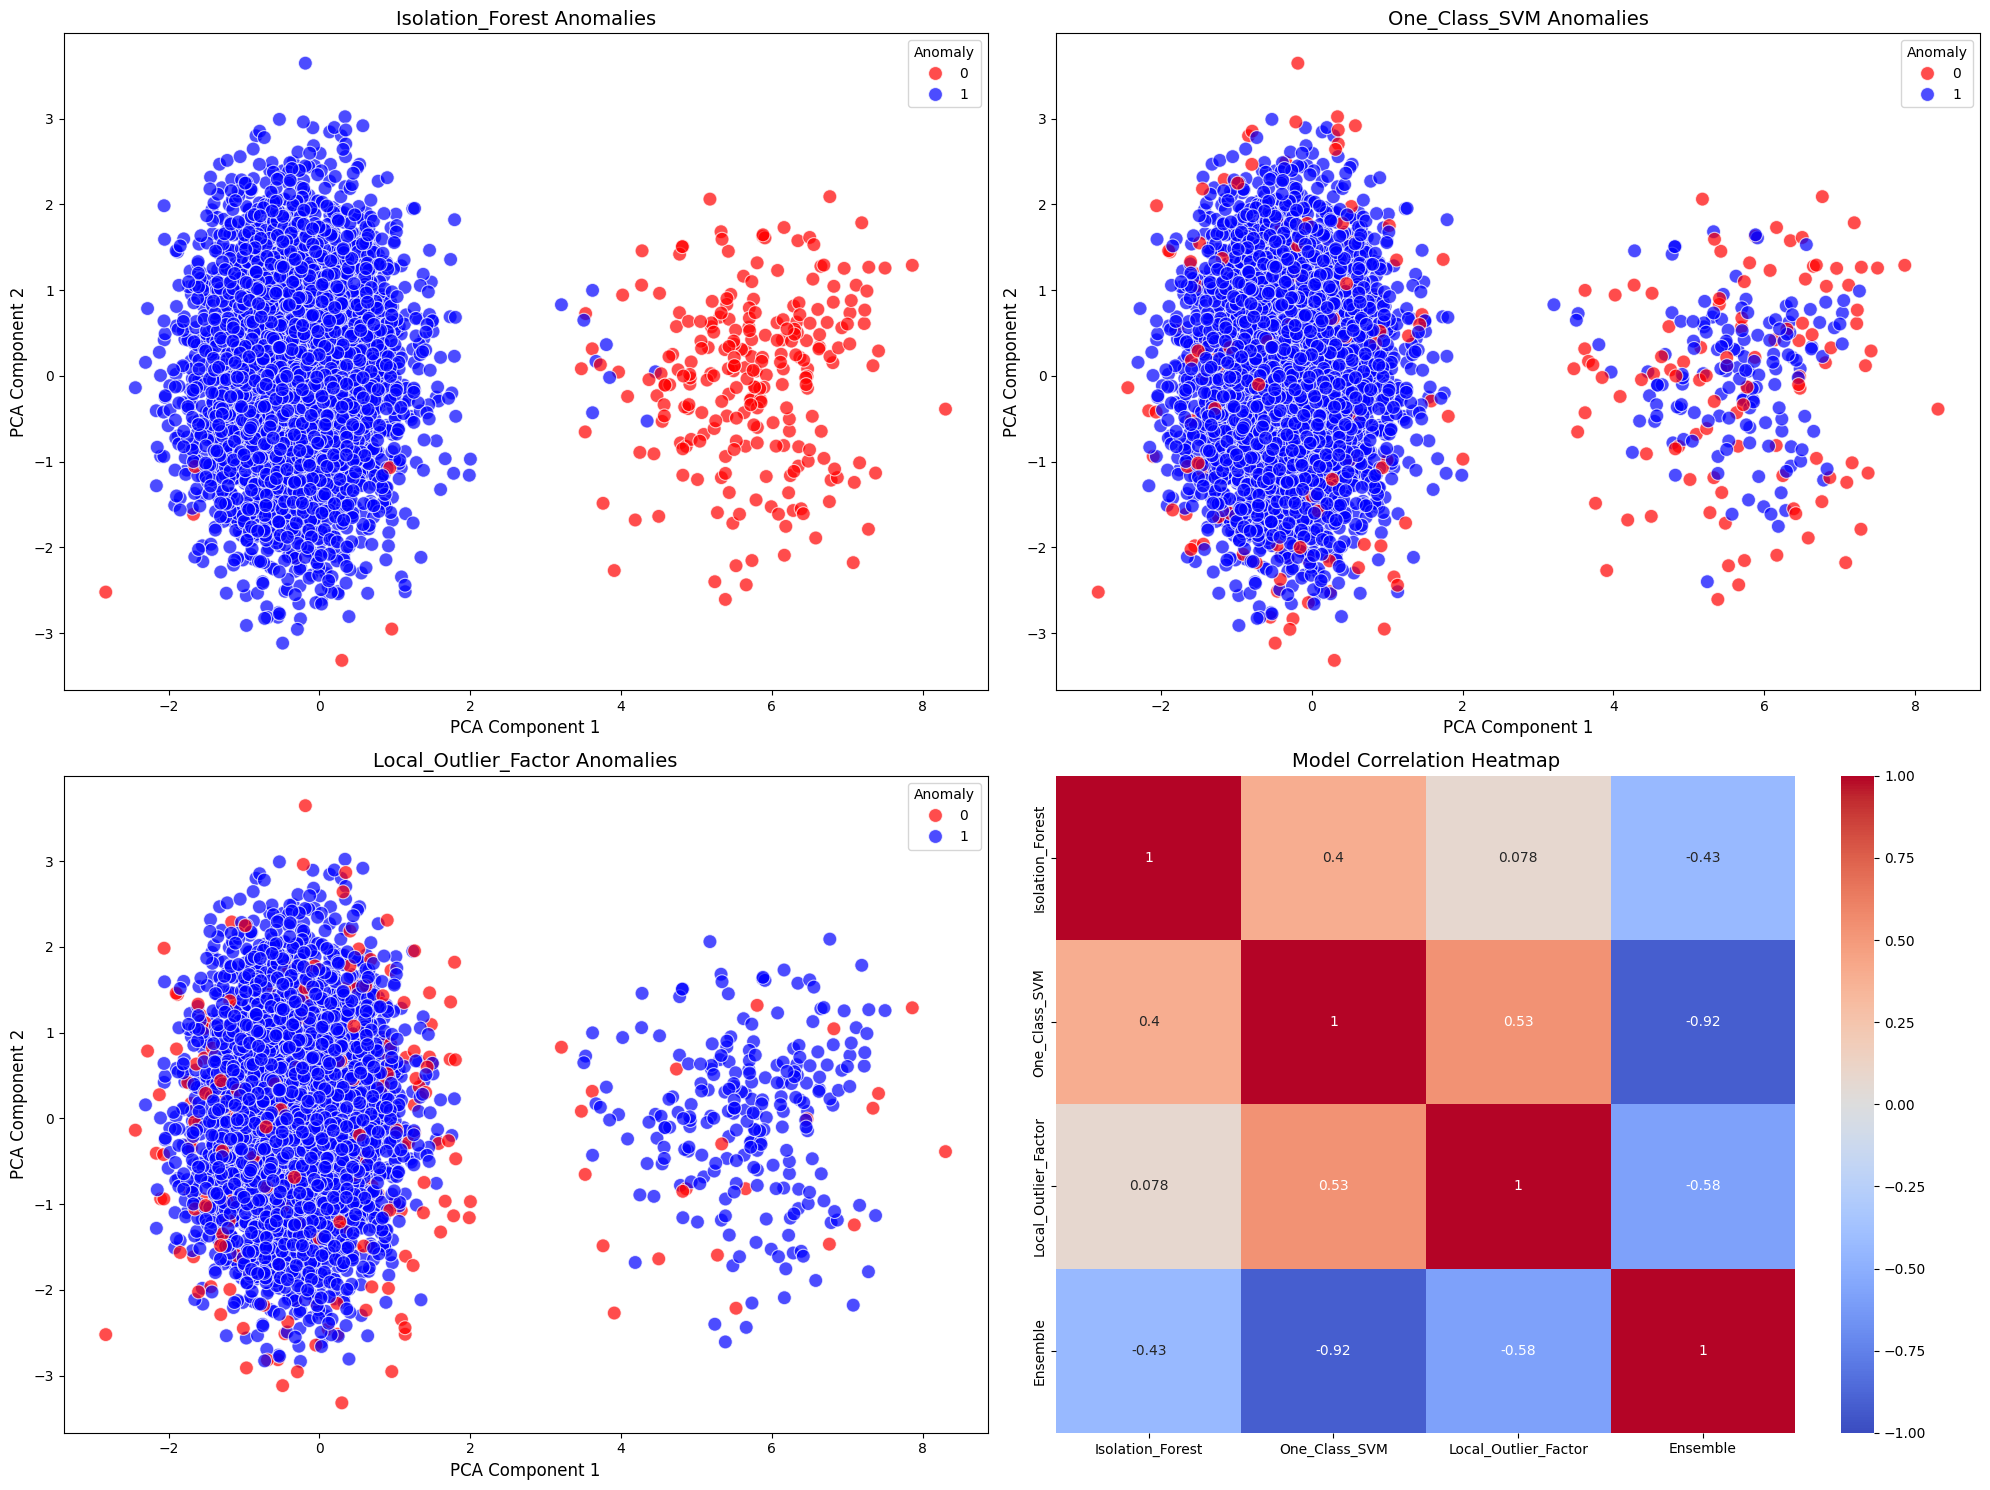

Streaming output truncated to the last 5000 lines.
Heart_Rate: 72.75
✅ All vitals within normal range.

Record: 4448
Age: 66.00
Blood_Pressure: 121.94
Cholesterol: 165.12
Glucose: 112.50
BMI: 24.49
Heart_Rate: 68.50
✅ All vitals within normal range.

Record: 4449
Age: 63.00
Blood_Pressure: 84.29
Cholesterol: 195.15
Glucose: 123.29
BMI: 24.19
Heart_Rate: 78.16
✅ All vitals within normal range.

Record: 4450
Age: 66.00
Blood_Pressure: 92.55
Cholesterol: 186.07
Glucose: 80.71
BMI: 16.15
Heart_Rate: 92.08
✅ All vitals within normal range.

Record: 4451
Age: 79.00
Blood_Pressure: 129.24
Cholesterol: 242.72
Glucose: 96.70
BMI: 30.04
Heart_Rate: 65.99
✅ All vitals within normal range.

Record: 4452
Age: 25.00
Blood_Pressure: 135.56
Cholesterol: 235.13
Glucose: 148.51
BMI: 20.22
Heart_Rate: 94.12
✅ All vitals within normal range.

Record: 4453
Age: 60.00
Blood_Pressure: 106.34
Cholesterol: 203.23
Glucose: 98.42
BMI: 23.82
Heart_Rate: 86.99
✅ All vitals within normal range.

Record: 4454
Age: 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import time
import random
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

class PatientHealthMonitor:
    def __init__(self):
        self.isolation_forest = IsolationForest(contamination=0.05, random_state=42)
        self.one_class_svm = OneClassSVM(nu=0.05)
        self.local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
        self.scaler = StandardScaler()
        self.email_config = {
            "sender_email": "your-email@gmail.com",
            "receiver_email": "xyz@gmail.com",
            "password": "your-app-password",
            "smtp_server": "smtp.gmail.com",
            "smtp_port": 587
        }

    def load_patient_data(self, file_path='public_health.csv'):
        """Load patient health data from CSV file"""
        df = pd.read_csv(file_path)
        print(f"Loaded {len(df)} records from {file_path}")

        # Assume there is no ground truth for anomalies in the file
        df["True_Anomaly"] = 0  # Initialize all as normal
        return df

    def load_surgery_data(self, file_path='public_health.csv', patient_id=None):
        """Load surgery data from CSV file"""
        df = pd.read_csv(file_path)
        print(f"Loaded {len(df)} surgery records from {file_path}")

        # Filter by patient_id if provided
        if patient_id and 'Patient_ID' in df.columns:
            df = df[df['Patient_ID'] == patient_id]
            print(f"Filtered to {len(df)} records for patient {patient_id}")

        # If there's no time column, add one
        if 'Time' not in df.columns:
            df['Time'] = range(len(df))

        # Assume there is no ground truth for anomalies in the file
        df["True_Anomaly"] = 0  # Initialize all as normal
        return df

    def detect_anomalies(self, df, features):
        """Detect anomalies using multiple algorithms"""
        X = df[features]
        X_scaled = self.scaler.fit_transform(X)

        # 1. Isolation Forest
        self.isolation_forest.fit(X_scaled)
        df["Isolation_Forest"] = self.isolation_forest.predict(X_scaled)
        df["Isolation_Forest"] = df["Isolation_Forest"].apply(lambda x: 0 if x == -1 else 1)  # 1 = Normal, 0 = Anomaly

        # 2. One-Class SVM
        self.one_class_svm.fit(X_scaled)
        df["One_Class_SVM"] = self.one_class_svm.predict(X_scaled)
        df["One_Class_SVM"] = df["One_Class_SVM"].apply(lambda x: 0 if x == -1 else 1)

        # 3. Local Outlier Factor
        df["Local_Outlier_Factor"] = self.local_outlier_factor.fit_predict(X_scaled)
        df["Local_Outlier_Factor"] = df["Local_Outlier_Factor"].apply(lambda x: 0 if x == -1 else 1)

        # 4. Ensemble voting (majority vote)
        df["Ensemble"] = ((df["Isolation_Forest"] + df["One_Class_SVM"] + df["Local_Outlier_Factor"]) < 2).astype(int)

        return df

    def evaluate_models(self, df):
        """Evaluate model performance using metrics"""
        models = ["Isolation_Forest", "One_Class_SVM", "Local_Outlier_Factor", "Ensemble"]
        results = []

        # Since we don't have ground truth, we'll just report the number of anomalies detected
        print("\n===== Model Detection Summary =====")
        for model in models:
            num_anomalies = df[df[model] == 0].shape[0]
            anomaly_percentage = (num_anomalies / len(df)) * 100

            print(f"\nModel: {model}")
            print(f"Anomalies Detected: {num_anomalies} ({anomaly_percentage:.2f}%)")

            results.append({
                "Model": model,
                "Anomalies Detected": num_anomalies,
                "Anomaly Percentage": anomaly_percentage
            })

        return results

    def visualize_results(self, df, features, save_path=None):
        """Visualize anomaly detection results"""
        # Reduce dimensionality for visualization
        X = df[features]
        X_scaled = self.scaler.transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        df["PCA1"] = X_pca[:, 0]
        df["PCA2"] = X_pca[:, 1]

        # Create visualization
        plt.figure(figsize=(20, 15))

        # Plot individual models
        models = ["Isolation_Forest", "One_Class_SVM", "Local_Outlier_Factor"]
        for i, model in enumerate(models):
            plt.subplot(2, 2, i+1)
            sns.scatterplot(
                x="PCA1", y="PCA2",
                hue=model,
                data=df,
                palette={0: "red", 1: "blue"},
                s=100, alpha=0.7
            )
            plt.title(f"{model} Anomalies", fontsize=14)
            plt.xlabel("PCA Component 1", fontsize=12)
            plt.ylabel("PCA Component 2", fontsize=12)
            plt.legend(title="Anomaly", loc="upper right")

        # Plot model correlation heatmap
        plt.subplot(2, 2, 4)
        correlation_columns = ["Isolation_Forest", "One_Class_SVM", "Local_Outlier_Factor", "Ensemble"]
        sns.heatmap(
            df[correlation_columns].corr(),
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1
        )
        plt.title("Model Correlation Heatmap", fontsize=14)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

    def send_email_alert(self, subject, message_body):
        """Send email alert when anomaly is detected"""
        print(f"Sending email alert: {subject}")

        # For demonstration, we'll just print the alert
        # In a real implementation, uncomment the following code:

        """
        message = MIMEMultipart()
        message["From"] = self.email_config["sender_email"]
        message["To"] = self.email_config["receiver_email"]
        message["Subject"] = subject

        message.attach(MIMEText(message_body, "plain"))

        try:
            server = smtplib.SMTP(self.email_config["smtp_server"], self.email_config["smtp_port"])
            server.starttls()
            server.login(self.email_config["sender_email"], self.email_config["password"])
            server.sendmail(
                self.email_config["sender_email"],
                self.email_config["receiver_email"],
                message.as_string()
            )
            server.quit()
            print("Email alert sent successfully!")
        except Exception as e:
            print(f"Failed to send email: {e}")
        """

    def monitor_patient_vitals(self, df, patient_id, time_delay=1):
        """Simulate real-time monitoring of patient vitals during surgery"""
        # Identify vital features by examining the columns in the dataframe
        vital_features = [col for col in df.columns if col not in ["Patient_ID", "Time", "True_Anomaly",
                                        "Isolation_Forest", "One_Class_SVM", "Local_Outlier_Factor", "Ensemble"]]

        print(f"\n===== Starting Real-time Monitoring for Patient {patient_id} =====")
        print(f"Monitoring features: {vital_features}")

        for index, row in df.iterrows():
            # Display current vital signs
            print(f"\nRecord: {index}")
            for feature in vital_features:
                print(f"{feature}: {row[feature]:.2f}")

            # Check for anomalies
            is_anomaly = row["Ensemble"] == 1

            if is_anomaly:
                alert_message = "⚠️ ALERT: Anomaly detected in patient vitals! ⚠️"
                print(alert_message)

                # Prepare email alert
                subject = f"MEDICAL ALERT: Anomaly Detected for Patient {patient_id}"
                message_body = f"""
                URGENT MEDICAL ALERT

                Patient ID: {patient_id}
                Record: {index}

                Anomaly detected in the following vital signs:
                """

                # Since we don't know the normal ranges for features in the input file,
                # we'll just report all features
                for feature in vital_features:
                    message_body += f"\n- {feature}: {row[feature]:.2f}"

                message_body += "\n\nPlease take immediate action."

                # Send email alert
                self.send_email_alert(subject, message_body)
            else:
                print("✅ All vitals within normal range.")

            # Simulate real-time delay
            if time_delay > 0:
                time.sleep(time_delay)

    def run_healthcare_analysis(self):
        """Run a complete healthcare data analysis"""
        # 1. Load patient data from CSV
        print("Loading patient health data from public_health.csv...")
        patient_df = self.load_patient_data('public_health.csv')

        # 2. Identify features for anomaly detection (exclude ID and other non-feature columns)
        # This assumes all numeric columns except Patient_ID are features
        patient_features = [col for col in patient_df.columns if col != 'Patient_ID' and col != 'True_Anomaly'
                           and patient_df[col].dtype in ['int64', 'float64']]

        print(f"Using features for anomaly detection: {patient_features}")

        # 3. Detect anomalies in patient data
        print("Detecting anomalies in patient health data...")
        patient_df = self.detect_anomalies(patient_df, patient_features)

        # 4. Evaluate models
        results = self.evaluate_models(patient_df)

        # 5. Visualize results
        self.visualize_results(patient_df, patient_features, save_path="patient_anomalies.png")

        # 6. Extract and save only the anomalous records
        anomalies_df = patient_df[patient_df["Ensemble"] == 1]
        anomalies_df.to_csv("detected_anomalies.csv", index=False)
        print(f"Detected {len(anomalies_df)} anomalies. Results saved to 'detected_anomalies.csv'")

        # Display anomalies
        print("\nPatient Health Anomalies Detected:")
        print(anomalies_df[["Patient_ID"] + patient_features].head(10))

        return patient_df, anomalies_df

    def run_surgery_simulation(self, time_delay=0):
        """Run a surgery simulation with real-time monitoring"""
        # 1. Load surgery data from CSV
        print("\nLoading surgery data from public_health.csv...")
        surgery_df = self.load_surgery_data('public_health.csv')

        # Get a random patient ID from the data if available
        if 'Patient_ID' in surgery_df.columns:
            patient_id = surgery_df['Patient_ID'].iloc[0]
        else:
            patient_id = "UNKNOWN"

        # 2. Identify features for anomaly detection (exclude ID and other non-feature columns)
        surgery_features = [col for col in surgery_df.columns if col not in ['Patient_ID', 'Time', 'True_Anomaly']
                           and surgery_df[col].dtype in ['int64', 'float64']]

        print(f"Using features for anomaly detection: {surgery_features}")

        # 3. Detect anomalies in surgery data
        print("Analyzing surgery vitals for anomalies...")
        surgery_df = self.detect_anomalies(surgery_df, surgery_features)

        # 4. Evaluate models
        results = self.evaluate_models(surgery_df)

        # 5. Monitor patient in real-time (with optional time delay)
        self.monitor_patient_vitals(surgery_df, patient_id, time_delay=time_delay)

        # 6. Extract and save only the anomalous records
        anomalies_df = surgery_df[surgery_df["Ensemble"] == 1]
        anomalies_df.to_csv(f"surgery_patient_{patient_id}_anomalies.csv", index=False)
        print(f"Detected {len(anomalies_df)} anomalies during surgery. Results saved to 'surgery_patient_{patient_id}_anomalies.csv'")

        return surgery_df, anomalies_df

# Main execution
if __name__ == "__main__":
    monitor = PatientHealthMonitor()

    print("=" * 80)
    print("PATIENT HEALTH ANOMALY DETECTION SYSTEM")
    print("=" * 80)

    # Run healthcare data analysis
    patient_df, patient_anomalies = monitor.run_healthcare_analysis()

    # Run surgery simulation (set time_delay=0 for faster execution, or 1 for real-time simulation)
    surgery_df, surgery_anomalies = monitor.run_surgery_simulation(time_delay=0)

    print("\nAnalysis complete. Thank you for using the Patient Health Anomaly Detection System.")

In [ ]:
from PIL import Image, ImageDraw
import numpy as np

# Input text (simulating the "hidden.png" content)
hidden_text = """
口带接口
带带接口
口带接口
""".strip().split('\n')

# Define character-to-color mapping
char_to_color = {
    '口': (255, 0, 0),    # Red (for borders)
    '带': (0, 0, 255),    # Blue (for fill)
    '接': (255, 255, 255),# White (ignored)
    ' ': (255, 255, 255)  # White (background)
}

# Create blank images
width, height = 300, 300
img1 = Image.new("RGB", (width, height), "white")  # First image (hollow square)
img2 = Image.new("RGB", (width, height), "white")  # Second image (vertical lines)
draw1 = ImageDraw.Draw(img1)
draw2 = ImageDraw.Draw(img2)

# Cell size (since it's a 3x3 grid)
cell_size = width // 3

# Process each character
for y, line in enumerate(hidden_text):
    for x, char in enumerate(line.strip()):
        # Define the rectangle for the current cell
        x1, y1 = x * cell_size, y * cell_size
        x2, y2 = x1 + cell_size, y1 + cell_size

        # Draw for Image 1 (hollow square)
        if char in char_to_color:
            draw1.rectangle([x1, y1, x2, y2], fill=char_to_color[char])

        # Draw for Image 2 (only '口' as vertical lines)
        if char == '口':
            draw2.rectangle([x1, y1, x2, y2], fill=(255, 0, 0))  # Red for '口'

# Save the images
img1.save("hollow_square.png")
img2.save("vertical_lines.png")

print("Images saved: hollow_square.png, vertical_lines.png")

Images saved: hollow_square.png, vertical_lines.png


In [ ]:
import os
from pwn import xor
print("With the Secure Server, sharing secrets is safer than ever!")
enc = bytes.fromhex(input("Enter the secret, XORed by your key (in hex): ").strip())
key = os.urandom(32)
enc2 = xor(enc,key).hex()
print(f"Double encrypted secret (in hex): {enc2}")
dec = bytes.fromhex(input("XOR the above with your key again (in hex): ").strip())
secret = xor(dec,key)
print("Secret received!")

ModuleNotFoundError: No module named 'pwn'

In [ ]:
from pwn import xor, unhex

# Given values in hexadecimal
enc_hex = "1e71ce4daffd2892b98791a20c3b7d1a3fa5e7ff05a2b0a83ba03"
enc2_hex = "e1930164280e44386b389f7e3bc02b707188ea70d9617e3ced989f15d8a10d70"
dec_hex = "eeo2c31a7f1fef8f92f75f1e60ba12df321925e8132068b0871ff303960e"

# Convert hexadecimal to raw bytes
enc = unhex(enc_hex)
enc2 = unhex(enc2_hex)
# 'eeo2...' has a typo, 'o' should be '0'
dec = unhex(dec_hex.replace('o', '0'))

# Compute key2
key2 = xor(enc, enc2)

# Recover secret
secret = xor(dec, key2)

print("Recovered secret:", secret.hex())

ModuleNotFoundError: No module named 'pwn'

In [ ]:
!pip install pwntools

from pwn import *

# Given values in hexadecimal
enc_hex = "1e71ce4daffd2892b98791a20c3b7d1a3fa5e7ff05a2b0a83ba03"
enc2_hex = "e1930164280e44386b389f7e3bc02b707188ea70d9617e3ced989f15d8a10d70"
dec_hex = "eeo2c31a7f1fef8f92f75f1e60ba12df321925e8132068b0871ff303960e"

# Convert hexadecimal to raw bytes
enc = unhex(enc_hex)
enc2 = unhex(enc2_hex)
# 'eeo2...' has a typo, 'o' should be '0'
dec = unhex(dec_hex.replace('o', '0'))

# Compute key2
key2 = xor(enc, enc2)

# Recover secret
secret = xor(dec, key2)

print("Recovered secret:", secret.hex())

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 11.2 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl

UnsupportedOperation: fileno

In [ ]:
def xor(a, b):
    return bytes([x ^ y for x, y in zip(a, b)])

# Given values in hexadecimal
enc_hex = "151e71ce4daffd2892b98791a20c3b7d1a3fa5e7ff05a2b0a83ba03"
enc2_hex = "e1930164280e44386b389f7e3bc02b707188ea70d9617e3ced989f15d8a10d70"
dec_hex = "87ee0c31a7f1fef8f92f75f1e60ba12df321925e8132068b0871ff303960e"

# Convert hexadecimal to raw bytes
enc = bytes.fromhex(enc_hex)
enc2 = bytes.fromhex(enc2_hex)
dec = bytes.fromhex(dec_hex)

# Compute key2
key2 = xor(enc, enc2)

# Recover secret
secret = xor(dec, key2)

print("Recovered secret:", secret.hex())

ValueError: non-hexadecimal number found in fromhex() arg at position 55

In [ ]:
def xor(a, b):
    return bytes([x ^ y for x, y in zip(a, b)])

# Given values in hexadecimal
enc_hex = "1e71ce4daffd2892b98791a20c3b7d1a3fa5e7ff05a2b0a83ba03"
enc2_hex = "e1930164280e44386b389f7e3bc02b707188ea70d9617e3ced989f15d8a10d70"
dec_hex = "ee0c31a7f1fef8f92f75f1e60ba12df321925e8132068b0871ff303960e"

# Convert hexadecimal to raw bytes
enc = bytes.fromhex(enc_hex)
enc2 = bytes.fromhex(enc2_hex)
dec = bytes.fromhex(dec_hex)

# Compute key2
key2 = xor(enc, enc2)

# Recover secret
secret = xor(dec, key2)

print("Recovered secret:", secret.hex())

ValueError: non-hexadecimal number found in fromhex() arg at position 53